In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Shows all columns as default
pd.set_option("display.max_columns", 500)

# Plot defaults
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linewidth"] = 0.25
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 12

### Basic level

**Read the main dataset using Pandas.**

In [2]:
acc_2016 = pd.read_csv(
    "./data/uk-2016-road-safety-data/dftRoadSafety_Accidents_2016.csv")

/home/jimmy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Check the number of rows and columns.**

In [3]:
acc_2016.shape # m x rows by n x columns

(136621, 32)

**Check the data type of each column.**

In [4]:
# Downcasting integers
acc_int = acc_2016.select_dtypes(include=["int"])
cnvt_int = acc_int.apply(pd.to_numeric, downcast="signed")  # pos and neg

# Downcasting floats
acc_float = acc_2016.select_dtypes(include=["float"])
cnvt_float = acc_float.apply(pd.to_numeric, downcast="float")

# Adding to temporary dataframe
opt = acc_2016.copy()
opt[cnvt_int.columns] = cnvt_int
opt[cnvt_float.columns] = cnvt_float

# Assigning some objects as categories
opt['Time'] = acc_2016['Time'].astype("category")
opt['Local_Authority_(Highway)'] = acc_2016[
    'Local_Authority_(Highway)'].astype("category")
opt['LSOA_of_Accident_Location'] = acc_2016[
    'LSOA_of_Accident_Location'].astype("category")

# Creating dictionary for the dataset to be read again
dtypes = opt.dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
col_types = dict(zip(dtypes_col, dtypes_type))

# Data types before and after changes
display("Before: ", acc_2016.dtypes, "After: ", opt.dtypes)

'Before: '

Accident_Index                                  object
Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude                                      float64
Latitude                                       float64
Police_Force                                     int64
Accident_Severity                                int64
Number_of_Vehicles                               int64
Number_of_Casualties                             int64
Date                                            object
Day_of_Week                                      int64
Time                                            object
Local_Authority_(District)                       int64
Local_Authority_(Highway)                       object
1st_Road_Class                                   int64
1st_Road_Number                                  int64
Road_Type                                        int64
Speed_limit                                    float64
Junction_D

'After: '

Accident_Index                                   object
Location_Easting_OSGR                           float32
Location_Northing_OSGR                          float32
Longitude                                       float32
Latitude                                        float32
Police_Force                                       int8
Accident_Severity                                  int8
Number_of_Vehicles                                 int8
Number_of_Casualties                               int8
Date                                             object
Day_of_Week                                        int8
Time                                           category
Local_Authority_(District)                        int16
Local_Authority_(Highway)                      category
1st_Road_Class                                     int8
1st_Road_Number                                   int16
Road_Type                                          int8
Speed_limit                                     

**Read the main dataset again, using `dtype={...}` argument to specify data types. See if you can avoid a mixed types warning.**

In [5]:
acc_2016 = pd.read_csv(
    "./data/uk-2016-road-safety-data/dftRoadSafety_Accidents_2016.csv", 
    dtype=col_types)

**Read the main dataset again, using an appropriate argument to specify missing data values.**

In [6]:
acc_2016.isnull().sum()

Accident_Index                                    0
Location_Easting_OSGR                             7
Location_Northing_OSGR                            7
Longitude                                         7
Latitude                                          7
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                              2
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                      37
Junction_Detail                                   0
Junction_Con

**Convert `Date` column to datetime.**

In [7]:
acc_2016['Date'] = pd.to_datetime(acc_2016['Date'], cache=True)

**Create a new column that shows month of a year value for every accident in the main dataset.**

In [8]:
acc_2016.insert(loc=10, 
                column='Month_Num',
                value=acc_2016['Date'].dt.month)

acc_2016.insert(loc=11, 
                column='Month_Name', 
                value=acc_2016['Date'].dt.month_name().astype("category"))

**Create a new column that shows hour of the day (24h format) for every accident in the main dataset.**

In [9]:
hour_value = pd.to_datetime(acc_2016['Time'], cache=True).dt.hour
acc_2016.insert(loc=13, column='Hour_of_Day', value=hour_value)

**Report average number of casualties depending on accident severity.**

In [10]:
# Loading data guide containing codes and labels 
guide = pd.read_excel(
    "./data/uk-2016-road-safety-data/Road-Accident-Safety-Data-Guide.xls", 
    sheet_name=None)

# Replacing accident severity codes with labels
acc_sev_dict = guide['Accident Severity'].set_index("code").T.to_dict("list")
acc_2016['Accident_Severity'].replace(acc_sev_dict, inplace=True)

# Mean number of casualties by accident severity
acc_2016.groupby('Accident_Severity')['Number_of_Casualties'].mean()

Accident_Severity
Fatal      1.775811
Serious    1.401749
Slight     1.306711
Name: Number_of_Casualties, dtype: float64

**Create a stacked barplot by accident severity occurrences in different months.** 

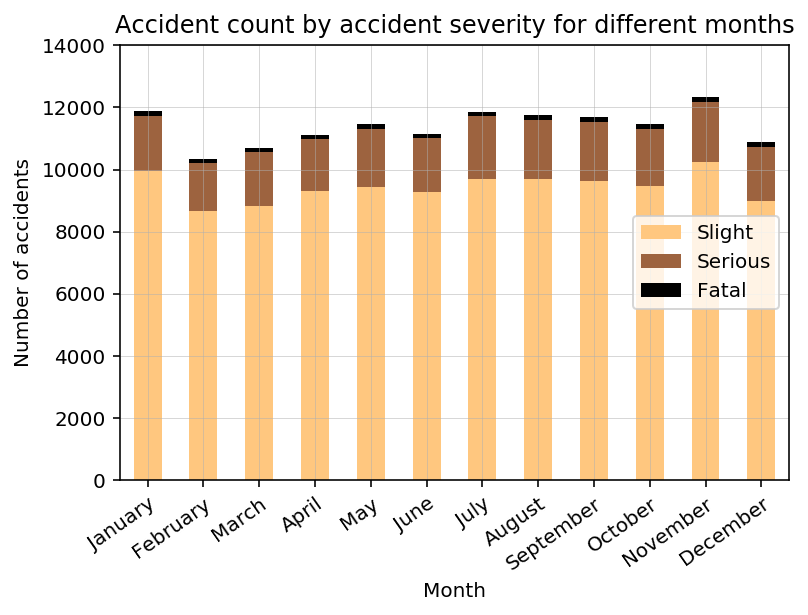

In [11]:
sbar = acc_2016.groupby('Month_Name', sort=False)\
    ['Accident_Severity'].value_counts().unstack()

# Reversing a stacked barplot
sbar.loc[:,::-1].plot(kind="bar", cmap="copper_r", ylim=[0,14000], stacked=True)

plt.xticks(rotation=35, rotation_mode="anchor", ha="right");
plt.title("Accident count by accident severity for different months");
plt.xlabel("Month");
plt.ylabel("Number of accidents");
plt.legend(loc=5);

- February has the least accidents across each severity
- January and November have the most acccidents

**Create a stacked barplot by accident severity occurrences in different months for the last full year of data only.** 

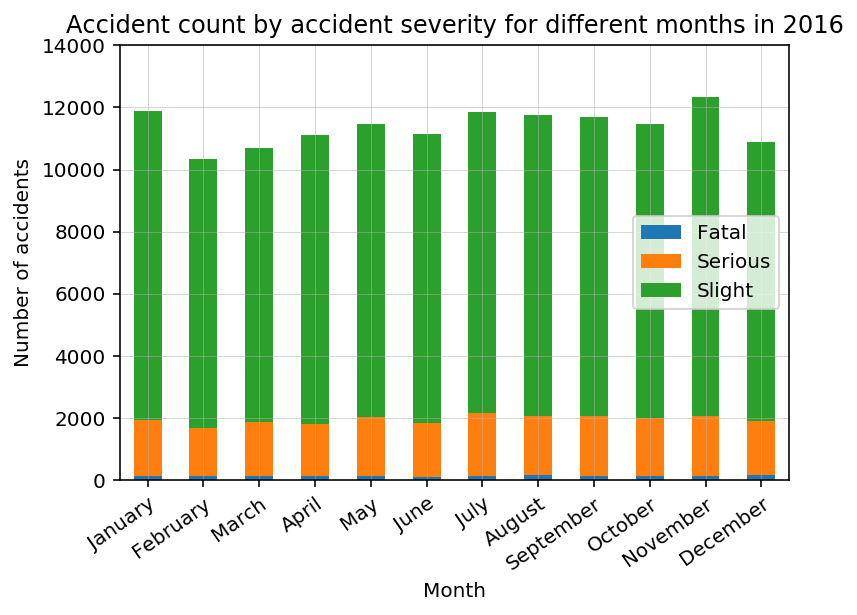

In [12]:
# Assigning a mask for 2016 calender year only
calendar_year_mask = np.logical_and((acc_2016['Date'] >= "2016-01-01"),
                                    (acc_2016['Date'] <= "2016-12-31"))

acc_2016[calendar_year_mask].groupby('Month_Name', sort=False)\
    ['Accident_Severity'].value_counts().unstack()\
        .plot(kind="bar", ylim=[0,14000], stacked=True)

plt.xticks(rotation=35, rotation_mode="anchor", ha="right");
plt.title("Accident count by accident severity for different months in 2016");
plt.xlabel("Month");
plt.ylabel("Number of accidents");
plt.legend(loc=5);

- Same as previous but includes a 2016 calender year mask

**Create a stacked barplot by accident severity occurrences based on the hour of the day.** 

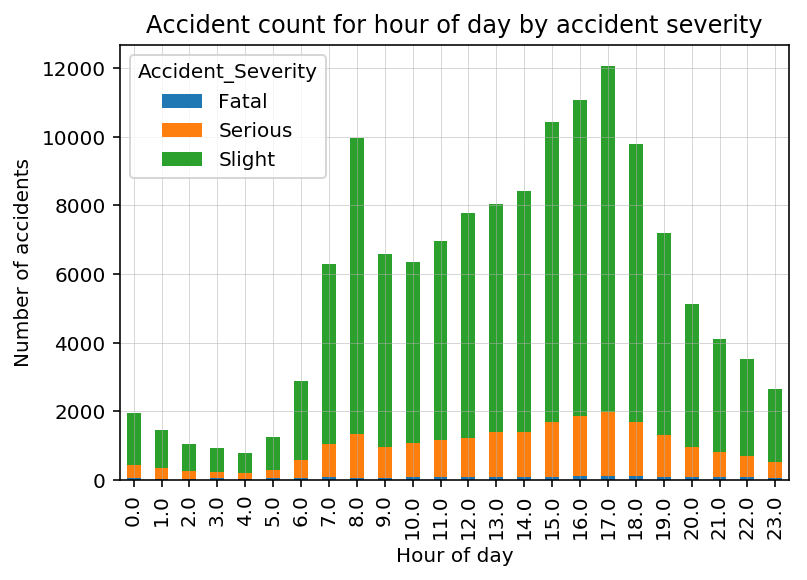

In [13]:
# Used another approach - crosstabs. 
# Noticed it forces lexical sorting on categorical data
pd.crosstab(acc_2016['Hour_of_Day'], 
            acc_2016['Accident_Severity']).plot(kind="bar", stacked=True)

plt.title("Accident count for hour of day by accident severity");
plt.xlabel("Hour of day");
plt.ylabel("Number of accidents");

- Most accidents in morning and afternoon correlating with peak traffic before and after work
- Least accidents after midnight

### Intermediate level

**Use appropriate plots for the following relationships:**
- Number of casualties by weather conditions
- Number of casualties by number of vehicles involved
- Number of casualties by hour of the day
- Number of casualties by month

#### Number of casualties by weather conditions

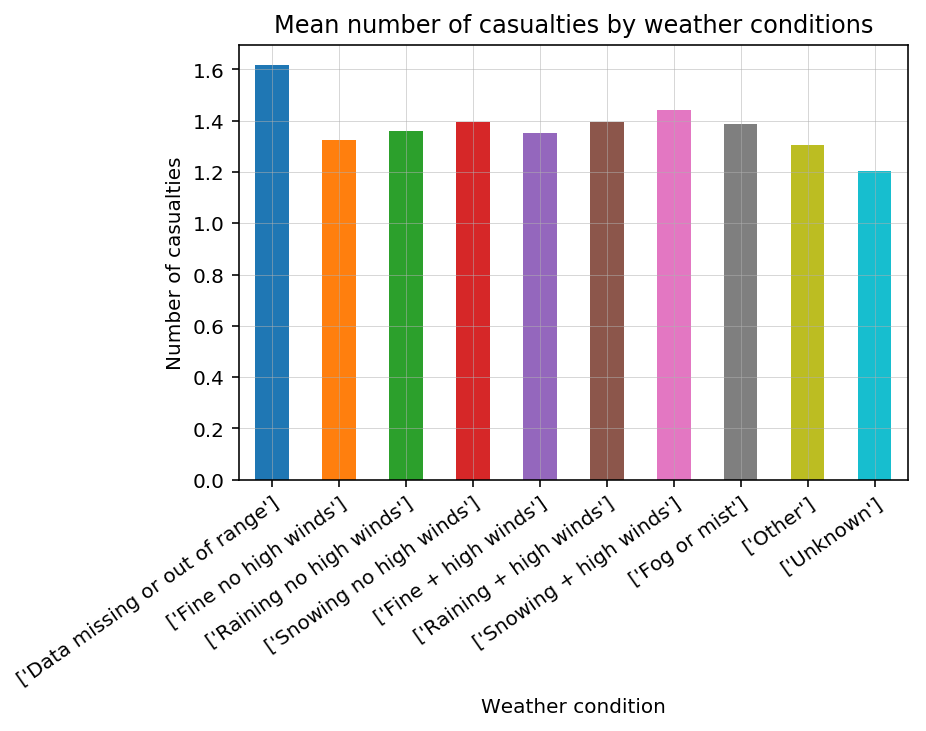

In [14]:
# Viewing weather codes with labels
weath_dict = guide['Weather'].set_index("code").T.to_dict("list")

weath_cas = acc_2016.groupby('Weather_Conditions')\
    ['Number_of_Casualties'].mean()
ax = weath_cas.plot(kind="bar")

# Adding labels to the x-axis using weather dictionary
x_labels = [weath_dict[x] for x in weath_cas.index]
ax.set_xticklabels(x_labels, rotation=35, rotation_mode="anchor", ha="right");

plt.title("Mean number of casualties by weather conditions");
plt.xlabel("Weather condition");
plt.ylabel("Number of casualties");

- Compared to a fine day; rain, snow, high winds and fog are all factors that increase the number of casualties
- The mean number of casualties are highest when it's snowing with high winds

#### Number of casualties by number of vehicles involved

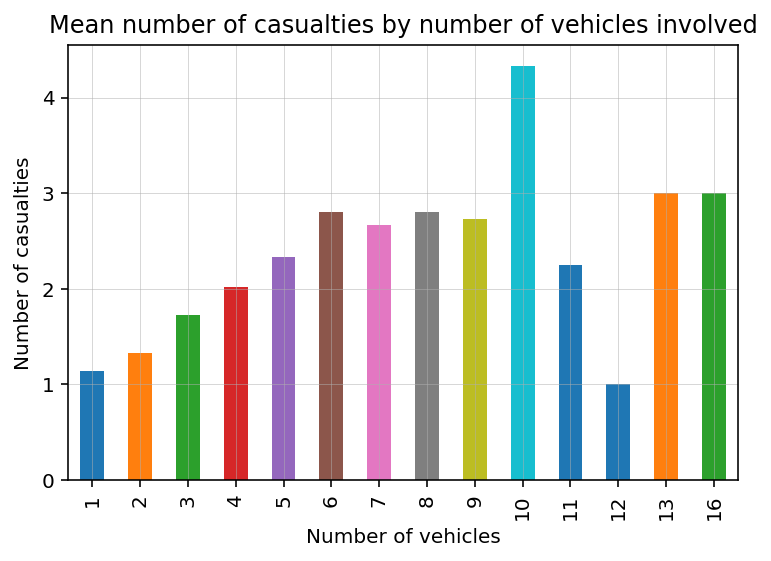

In [15]:
acc_2016.groupby('Number_of_Vehicles')['Number_of_Casualties'].mean()\
    .plot(kind="bar")

plt.title("Mean number of casualties by number of vehicles involved");
plt.xlabel("Number of vehicles");
plt.ylabel("Number of casualties");

- The mean number of casualties increase as the number of vehicles involved increase
- The mean number of casualties plateaus after 6 vehicles
- It is possible there is insufficient data for 10 or more vehicles

#### Number of casualties by hour of the day

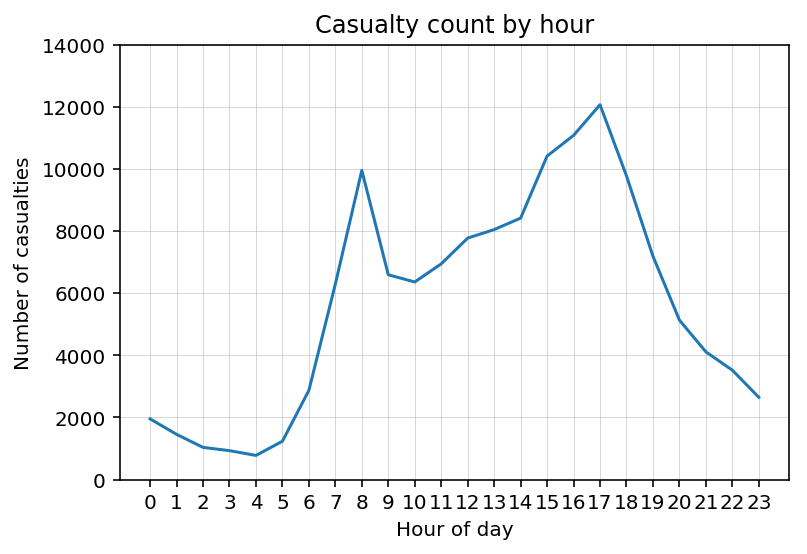

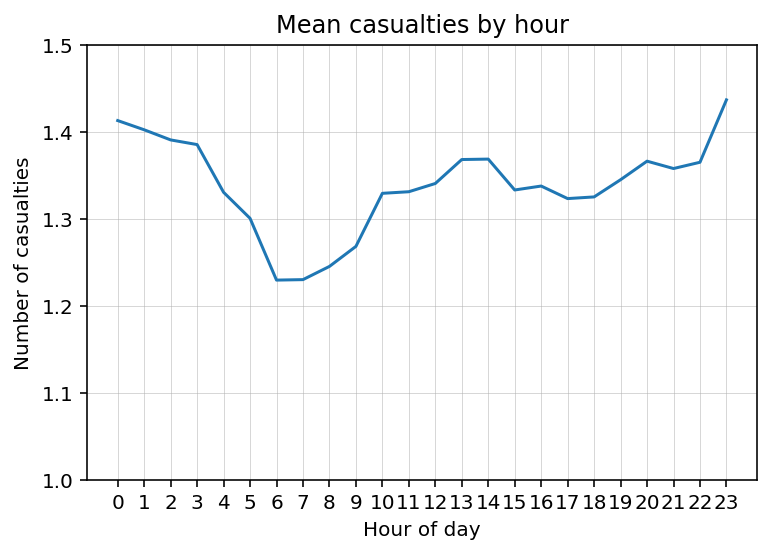

In [16]:
acc_2016.groupby('Hour_of_Day')['Number_of_Casualties'].count()\
    .plot(xticks=range(24), ylim=[0,14000])

plt.title("Casualty count by hour");
plt.xlabel("Hour of day");
plt.ylabel("Number of casualties");
plt.show();

acc_2016.groupby('Hour_of_Day')['Number_of_Casualties'].mean()\
    .plot(xticks=range(24), ylim=[1,1.5])

plt.title("Mean casualties by hour");
plt.xlabel("Hour of day");
plt.ylabel("Number of casualties");
plt.show();

- There are more casualties during the day due to more accidents
- However, there are more casualties per accident, on average, closer to midnight

#### Number of casualties by month

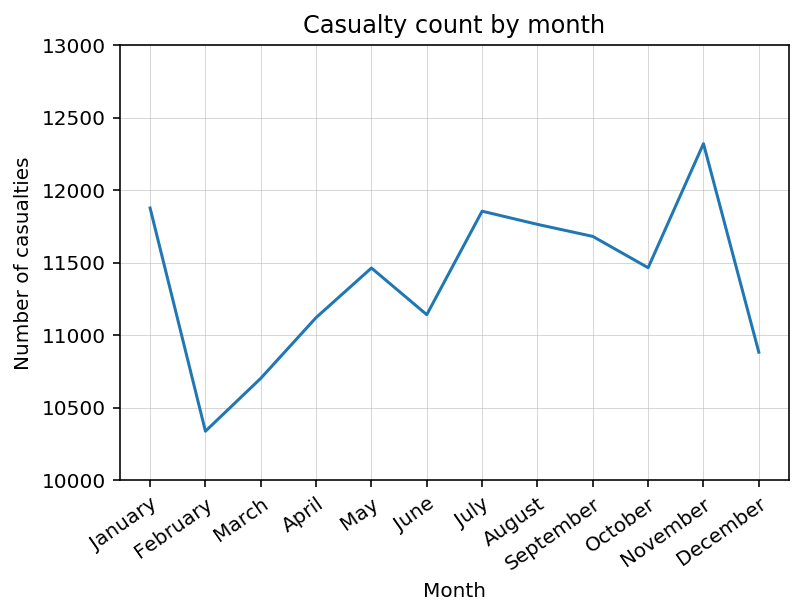

In [17]:
acc_2016.groupby('Month_Name', sort=False)['Number_of_Casualties'].count()\
    .plot(xticks=range(12), ylim=[10000,13000])

plt.xticks(rotation=35, rotation_mode="anchor", ha="right");
plt.title("Casualty count by month");
plt.xlabel("Month");
plt.ylabel("Number of casualties");

- February has the fewest casualties and November has the greatest

**Describe a nature of relationship between speed limit and accident severity.**

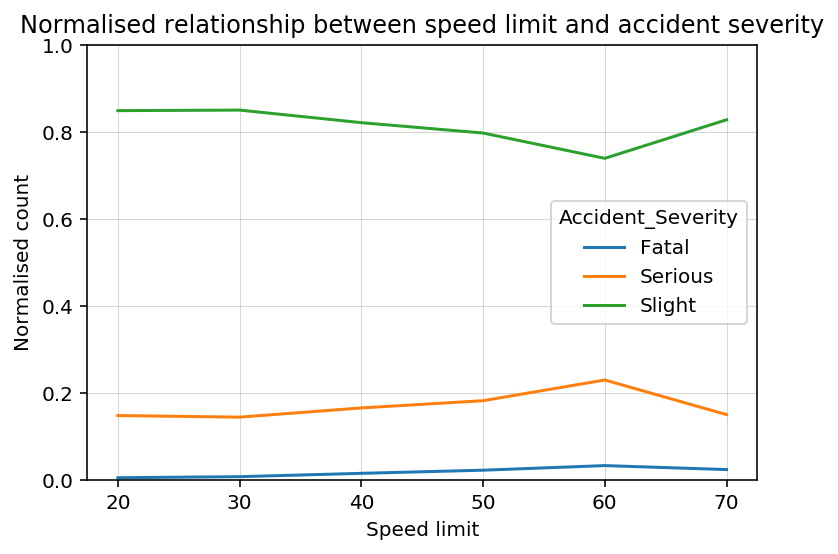

In [18]:
pd.crosstab(acc_2016['Speed_limit'], 
            acc_2016['Accident_Severity'], 
            normalize="index").plot(ylim=[0,1])

plt.title("Normalised relationship between speed limit and accident severity");
plt.xlabel("Speed limit");
plt.ylabel("Normalised count");

- By normalising accident severity count, we see the likelihood of `Fatal` and `Serious` accidents increase with speed limit
- `Slight` accidents decrease with `Speed_Limit`
- There is an exception when `Speed_Limit` reaches 70

**Load `Casuality` and `Vehicle` datasets and combine them with your base dataset.**

In [19]:
cas_2016 = pd.read_csv("./data/uk-2016-road-safety-data/Cas.csv")
veh_2016 = pd.read_csv("./data/uk-2016-road-safety-data/Veh.csv")

# Downcasting integers for veh_2016
veh_int = veh_2016.select_dtypes(include=["int"])
cnvt_int = veh_int.apply(pd.to_numeric, downcast="signed")

# Adding to temporary df
opt = veh_2016.copy()
opt[cnvt_int.columns] = cnvt_int

# Creating dictionary for the dataset to be read again
dtypes = opt.dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
col_types = dict(zip(dtypes_col, dtypes_type))

# Reading vehicle dataset again and specifying datatypes
veh_2016 = pd.read_csv("./data/uk-2016-road-safety-data/Veh.csv", 
                       dtype=col_types)

# Outer join casualty and vehicle datasets
cas_veh_2016 = pd.merge(cas_2016, veh_2016, 
                        how="outer", 
                        on=('Accident_Index', 'Vehicle_Reference'))

# Left join accident dataset with casualty and vehicle dataset
acc_cas_veh = pd.merge(acc_2016, cas_veh_2016, 
                       how="left", 
                       on='Accident_Index')

**Visualise/Describe relationships between:**
- casualty severity
- engine capacity
- driver age
- vehicle age
- hour of the accident
- month of the accident

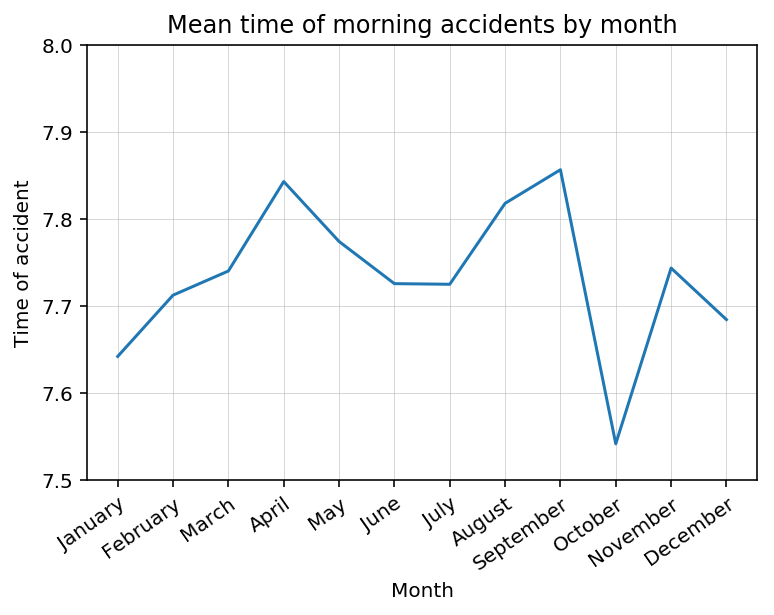

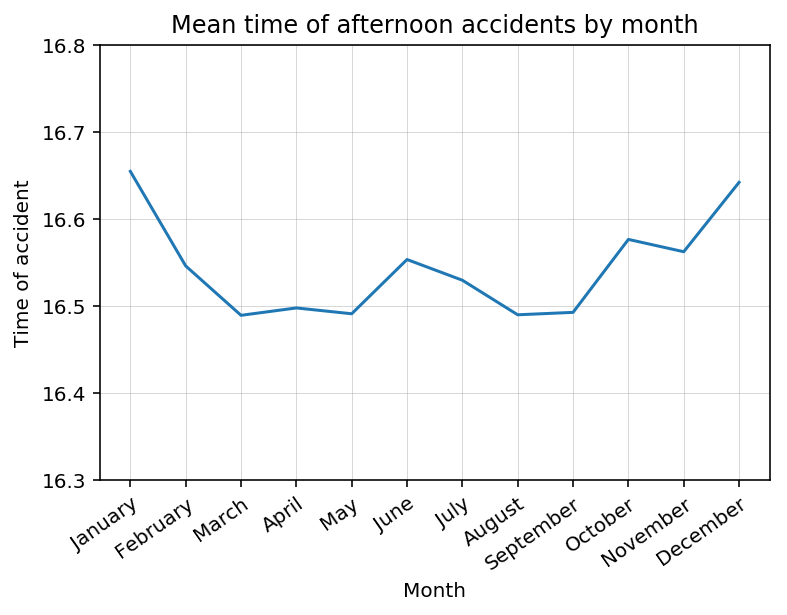

In [20]:
# A list of variables we want to visualise a relationship
cols = ['Casualty_Severity', 'Age_of_Driver', 'Age_of_Vehicle', 
        'Engine_Capacity_(CC)', 'Hour_of_Day', 'Month_Num']

# Replacing uknown values (-1) as NaN
acc_cas_veh['Engine_Capacity_(CC)'].replace(-1, np.NaN, inplace=True)
acc_cas_veh['Age_of_Vehicle'].replace(-1, np.NaN, inplace=True)
acc_cas_veh['Age_of_Driver'].replace(-1, np.NaN, inplace=True)

# Replacing NaN values as median
acc_cas_veh['Engine_Capacity_(CC)'].fillna(
    acc_cas_veh['Engine_Capacity_(CC)'].median(), inplace=True)
acc_cas_veh['Age_of_Vehicle'].fillna(
    acc_cas_veh['Age_of_Vehicle'].median(), inplace=True)
acc_cas_veh['Age_of_Driver'].fillna(
    acc_cas_veh['Age_of_Driver'].median(), inplace=True)

# Viewing casualty severity codes with labels
cas_sev_dict = guide['Casualty Severity'].set_index("code").T.to_dict("list")

# Assigning a mask for morning and afternoon
am_mask = acc_cas_veh['Hour_of_Day'] < 12
pm_mask = acc_cas_veh['Hour_of_Day'] >= 12

# Plotting morning accidents
acc_cas_veh[am_mask].groupby('Month_Name', sort=False)['Hour_of_Day'].mean()\
    .plot(xticks=range(12), ylim=[7.5,8])
plt.xticks(rotation=35, rotation_mode="anchor", ha="right");
plt.title("Mean time of morning accidents by month");
plt.xlabel("Month");
plt.ylabel("Time of accident");
plt.show();

# Plotting afternoon accidents
acc_cas_veh[pm_mask].groupby('Month_Name', sort=False)['Hour_of_Day'].mean()\
    .plot(xticks=range(12), ylim=[16.3,16.8])
plt.xticks(rotation=35, rotation_mode="anchor", ha="right");
plt.title("Mean time of afternoon accidents by month");
plt.xlabel("Month");
plt.ylabel("Time of accident");
plt.show();

- Accidents happen closer to midday during mid-year
- Possibly due to:
    - increased sunlight during their Summer, so better visibility throughout day
    - daylight savings in March and October influencing the time of accidents

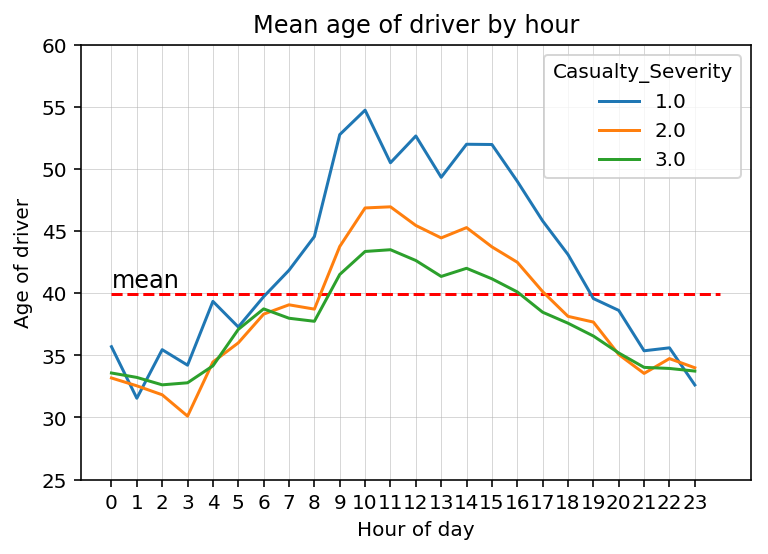

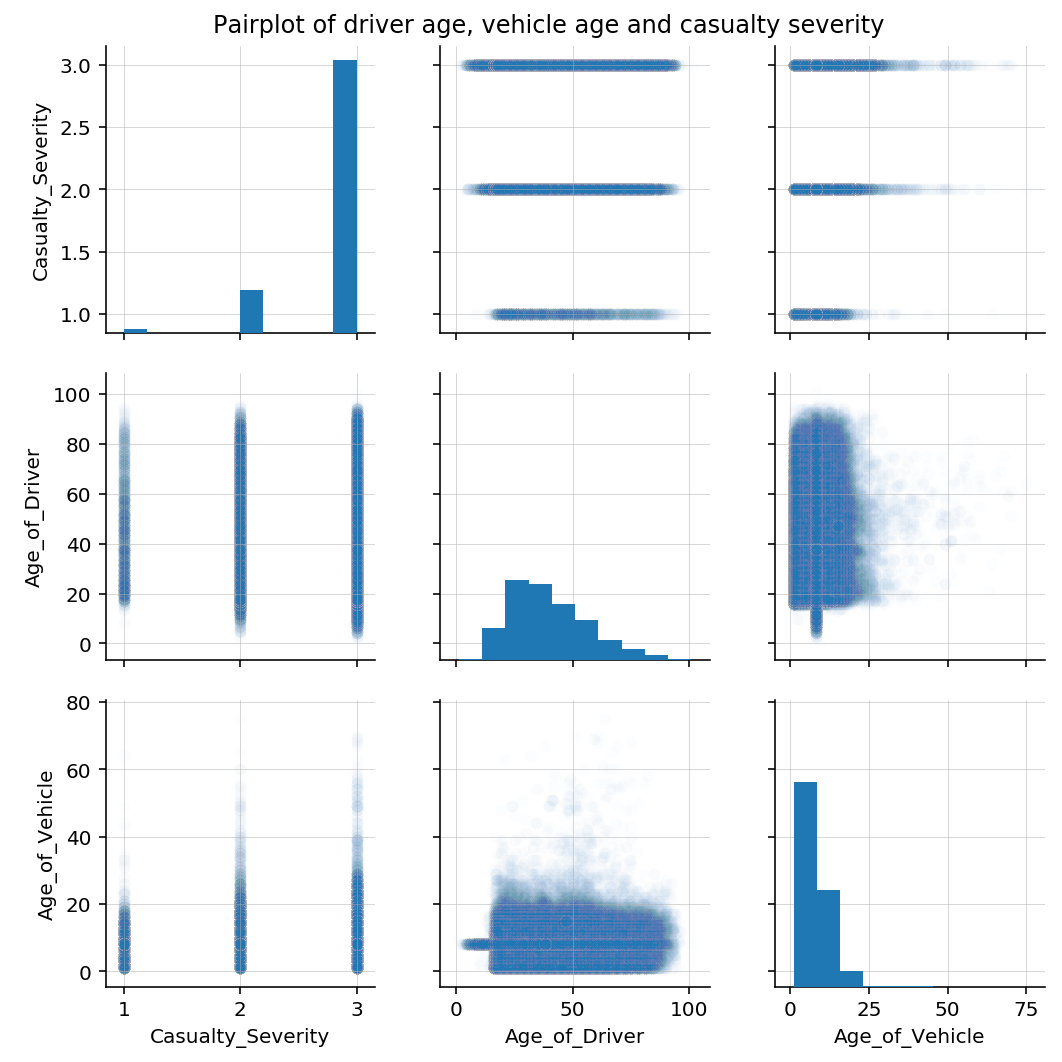

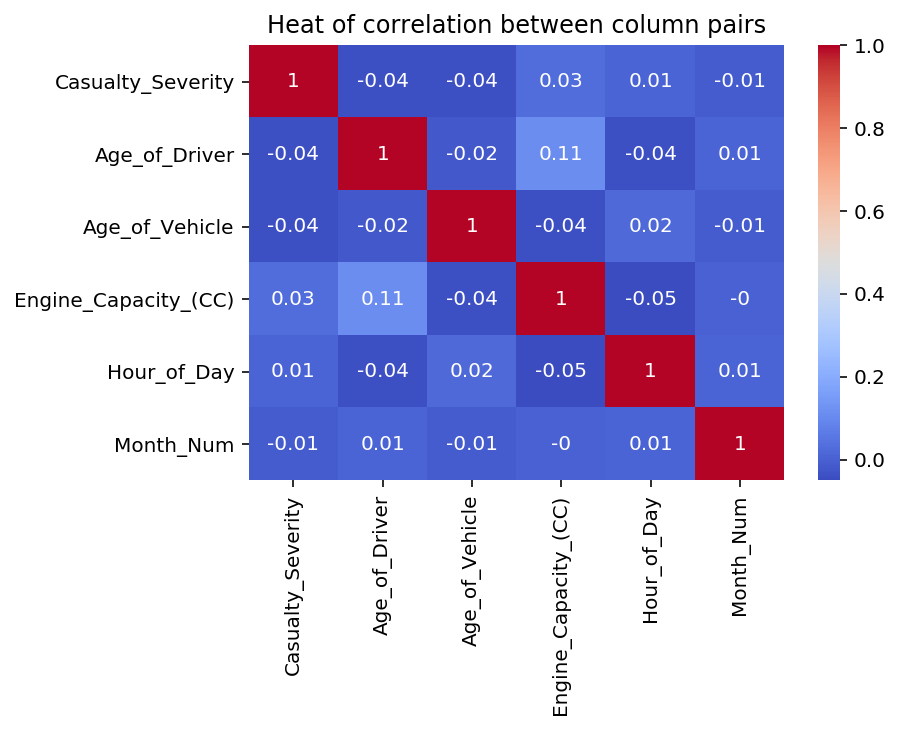

In [21]:
acc_cas_veh.groupby(['Hour_of_Day', 'Casualty_Severity'])\
    ['Age_of_Driver'].mean().unstack().plot(xticks=range(24), ylim=[25,60])

# Adding a horizontal line for mean age
plt.hlines(y=acc_cas_veh['Age_of_Driver'].mean(), 
           xmin=0, xmax=24, 
           color="r", linestyle="--")
plt.text(0, 40.5, str("mean"), fontsize=12)
plt.title("Mean age of driver by hour");
plt.xlabel("Hour of day");
plt.ylabel("Age of driver");
plt.show();

# Visualise distribution and relationships
g = sns.pairplot(acc_cas_veh[cols[0:3]].dropna(), plot_kws={"alpha": 0.01})
g.fig.suptitle("Pairplot of driver age, vehicle age and casualty severity")
plt.subplots_adjust(top=0.95)       # Extra spacing for title
plt.show();

# Visualise correlation between pairs
sns.heatmap(acc_cas_veh[cols].corr().round(2), cmap="coolwarm", annot=True)
plt.title("Heat of correlation between column pairs")
plt.show();

- Line graph show
    - Younger drivers are more likely to be in accidents early morning and at night
    - Older drivers are more likely to be in acciednts during the day
    - Older drivers are more likely to be involved in fatal accidents
- Pairplot shows
    - Age of driver is right skewed distribution
    - Age of vehicle is half normal distribution
    - Age of driver to age of vehicle is uniform (ie. no strong relationship)
- Heatmap shows weak correlation between these features

### Advanced level

**Repeat the last intermediate task using the same 6 features, but consider the relationships for people using cars (excluding minibuses, buses, vans, and goods vehicles), motorcycles (including electric motorcycles), and bicycles separately.**

What sample size % would you like to evaluate? 1


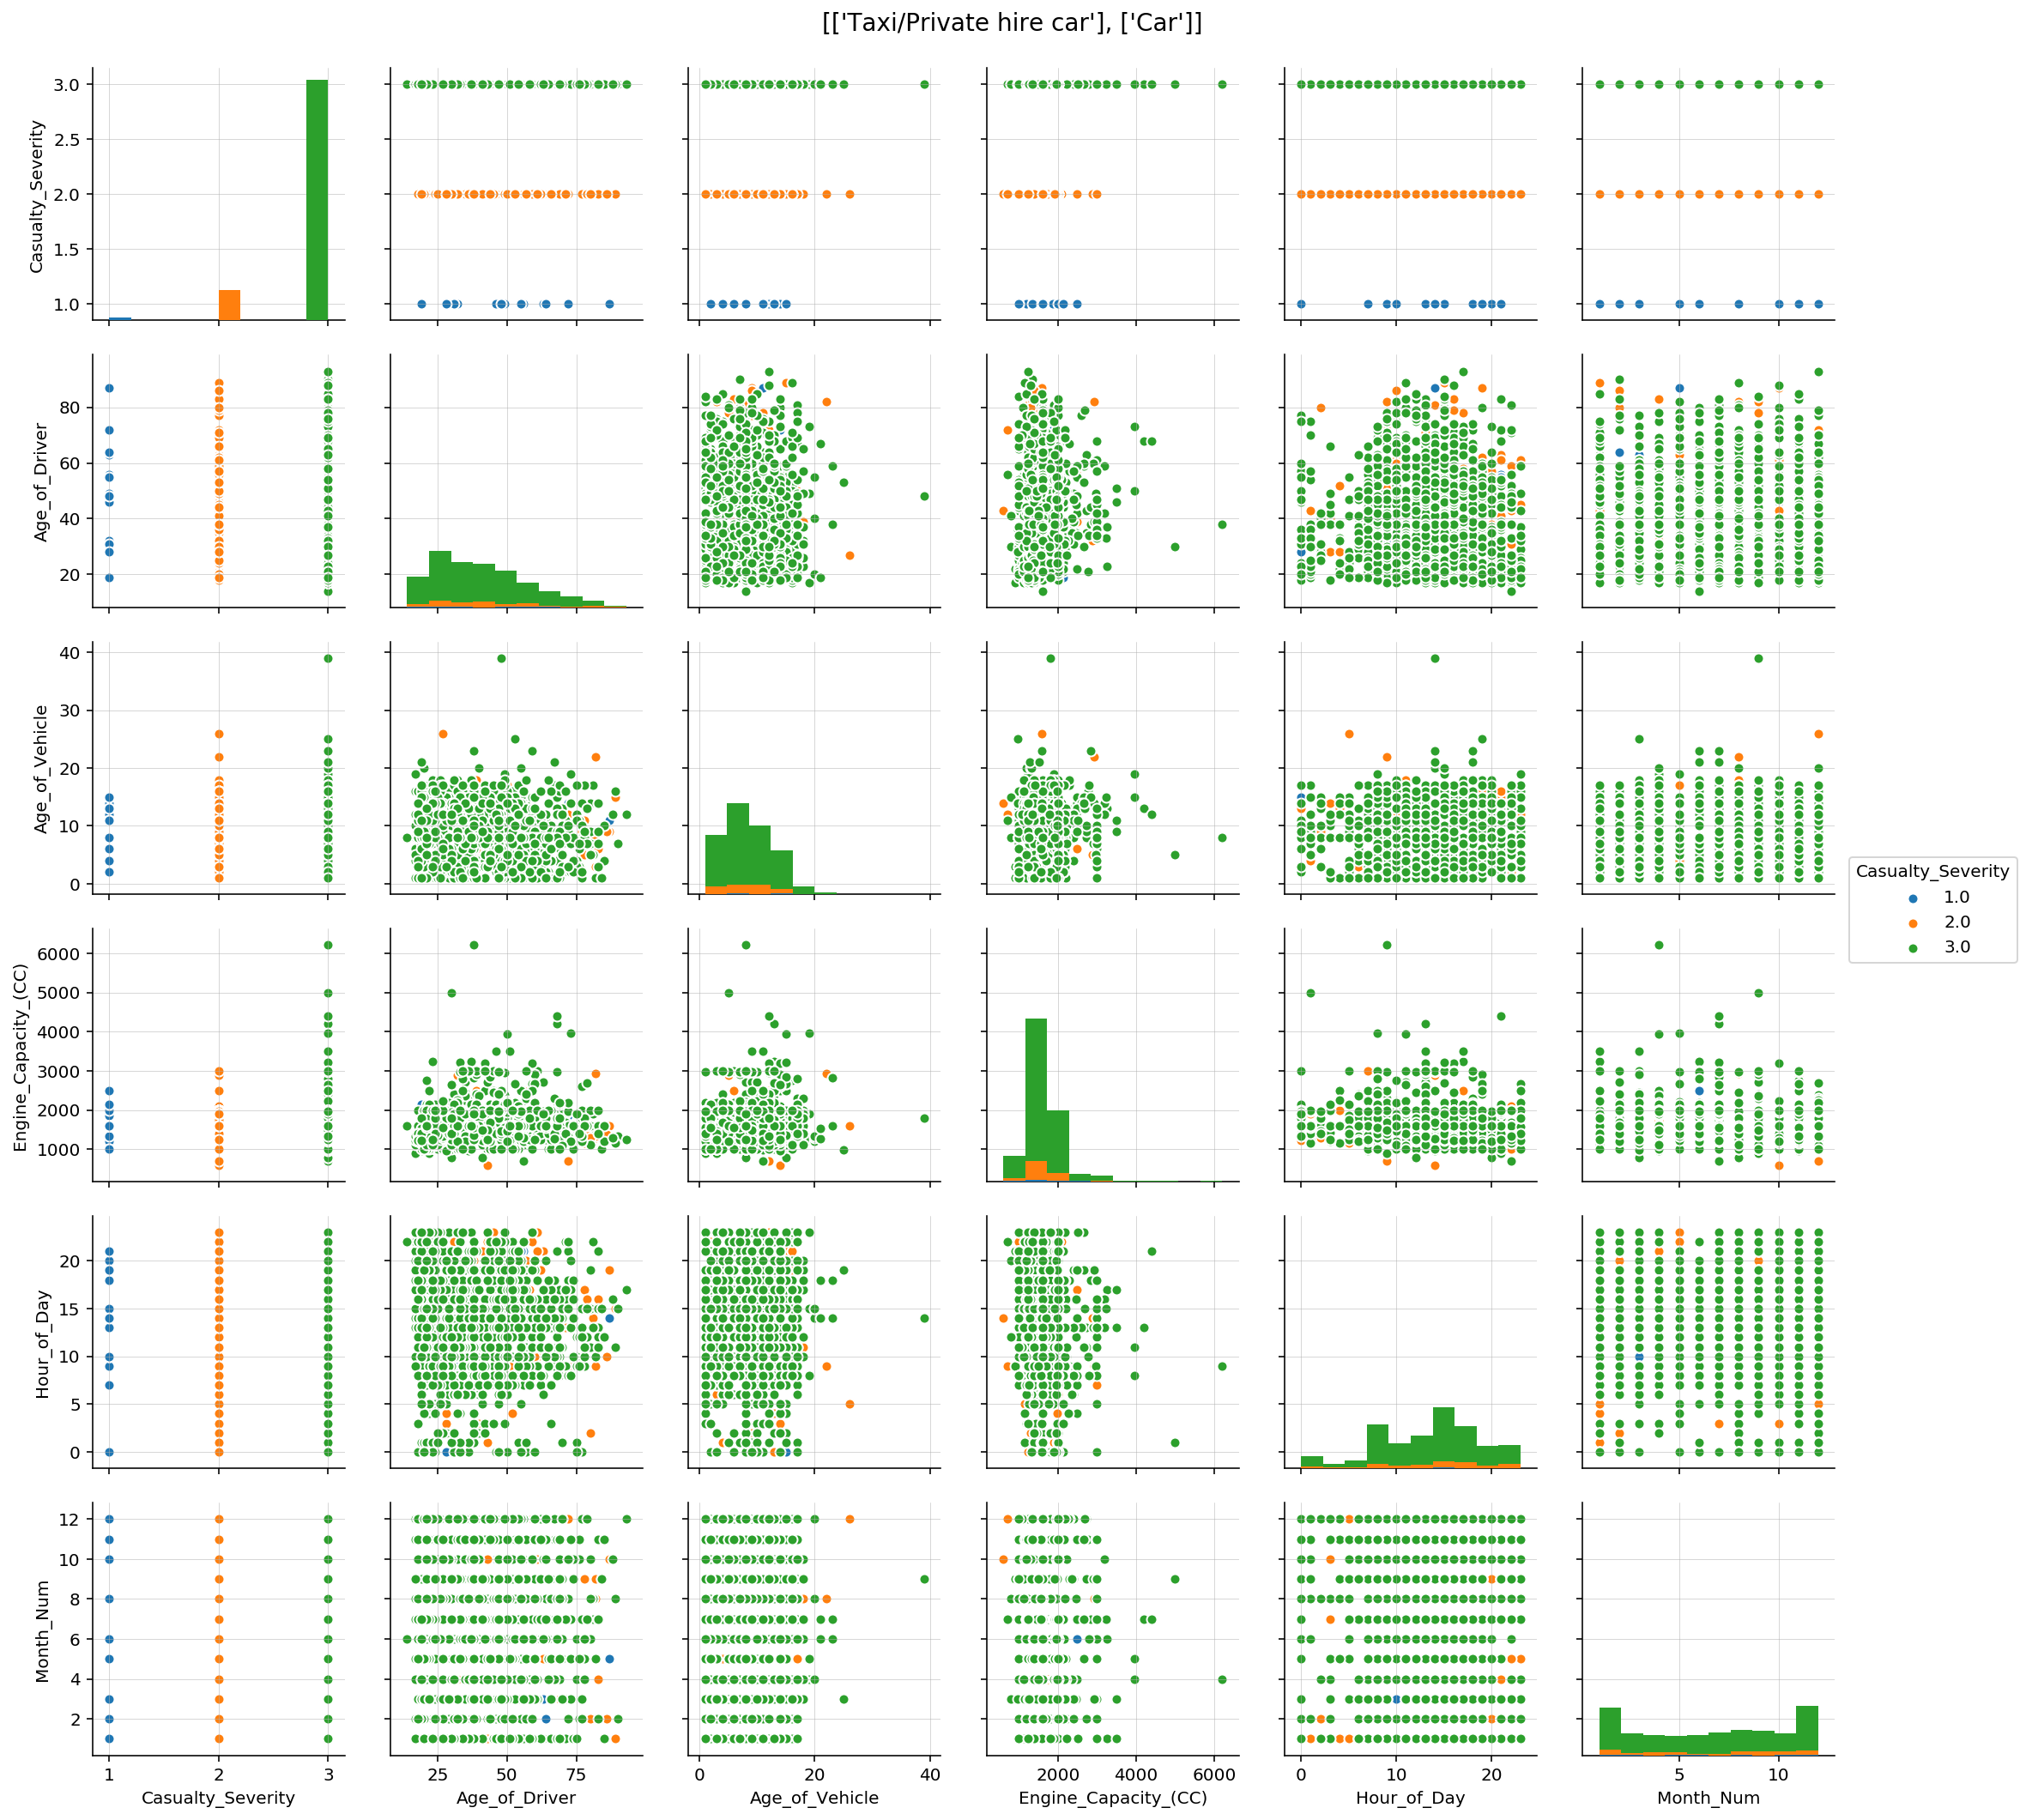

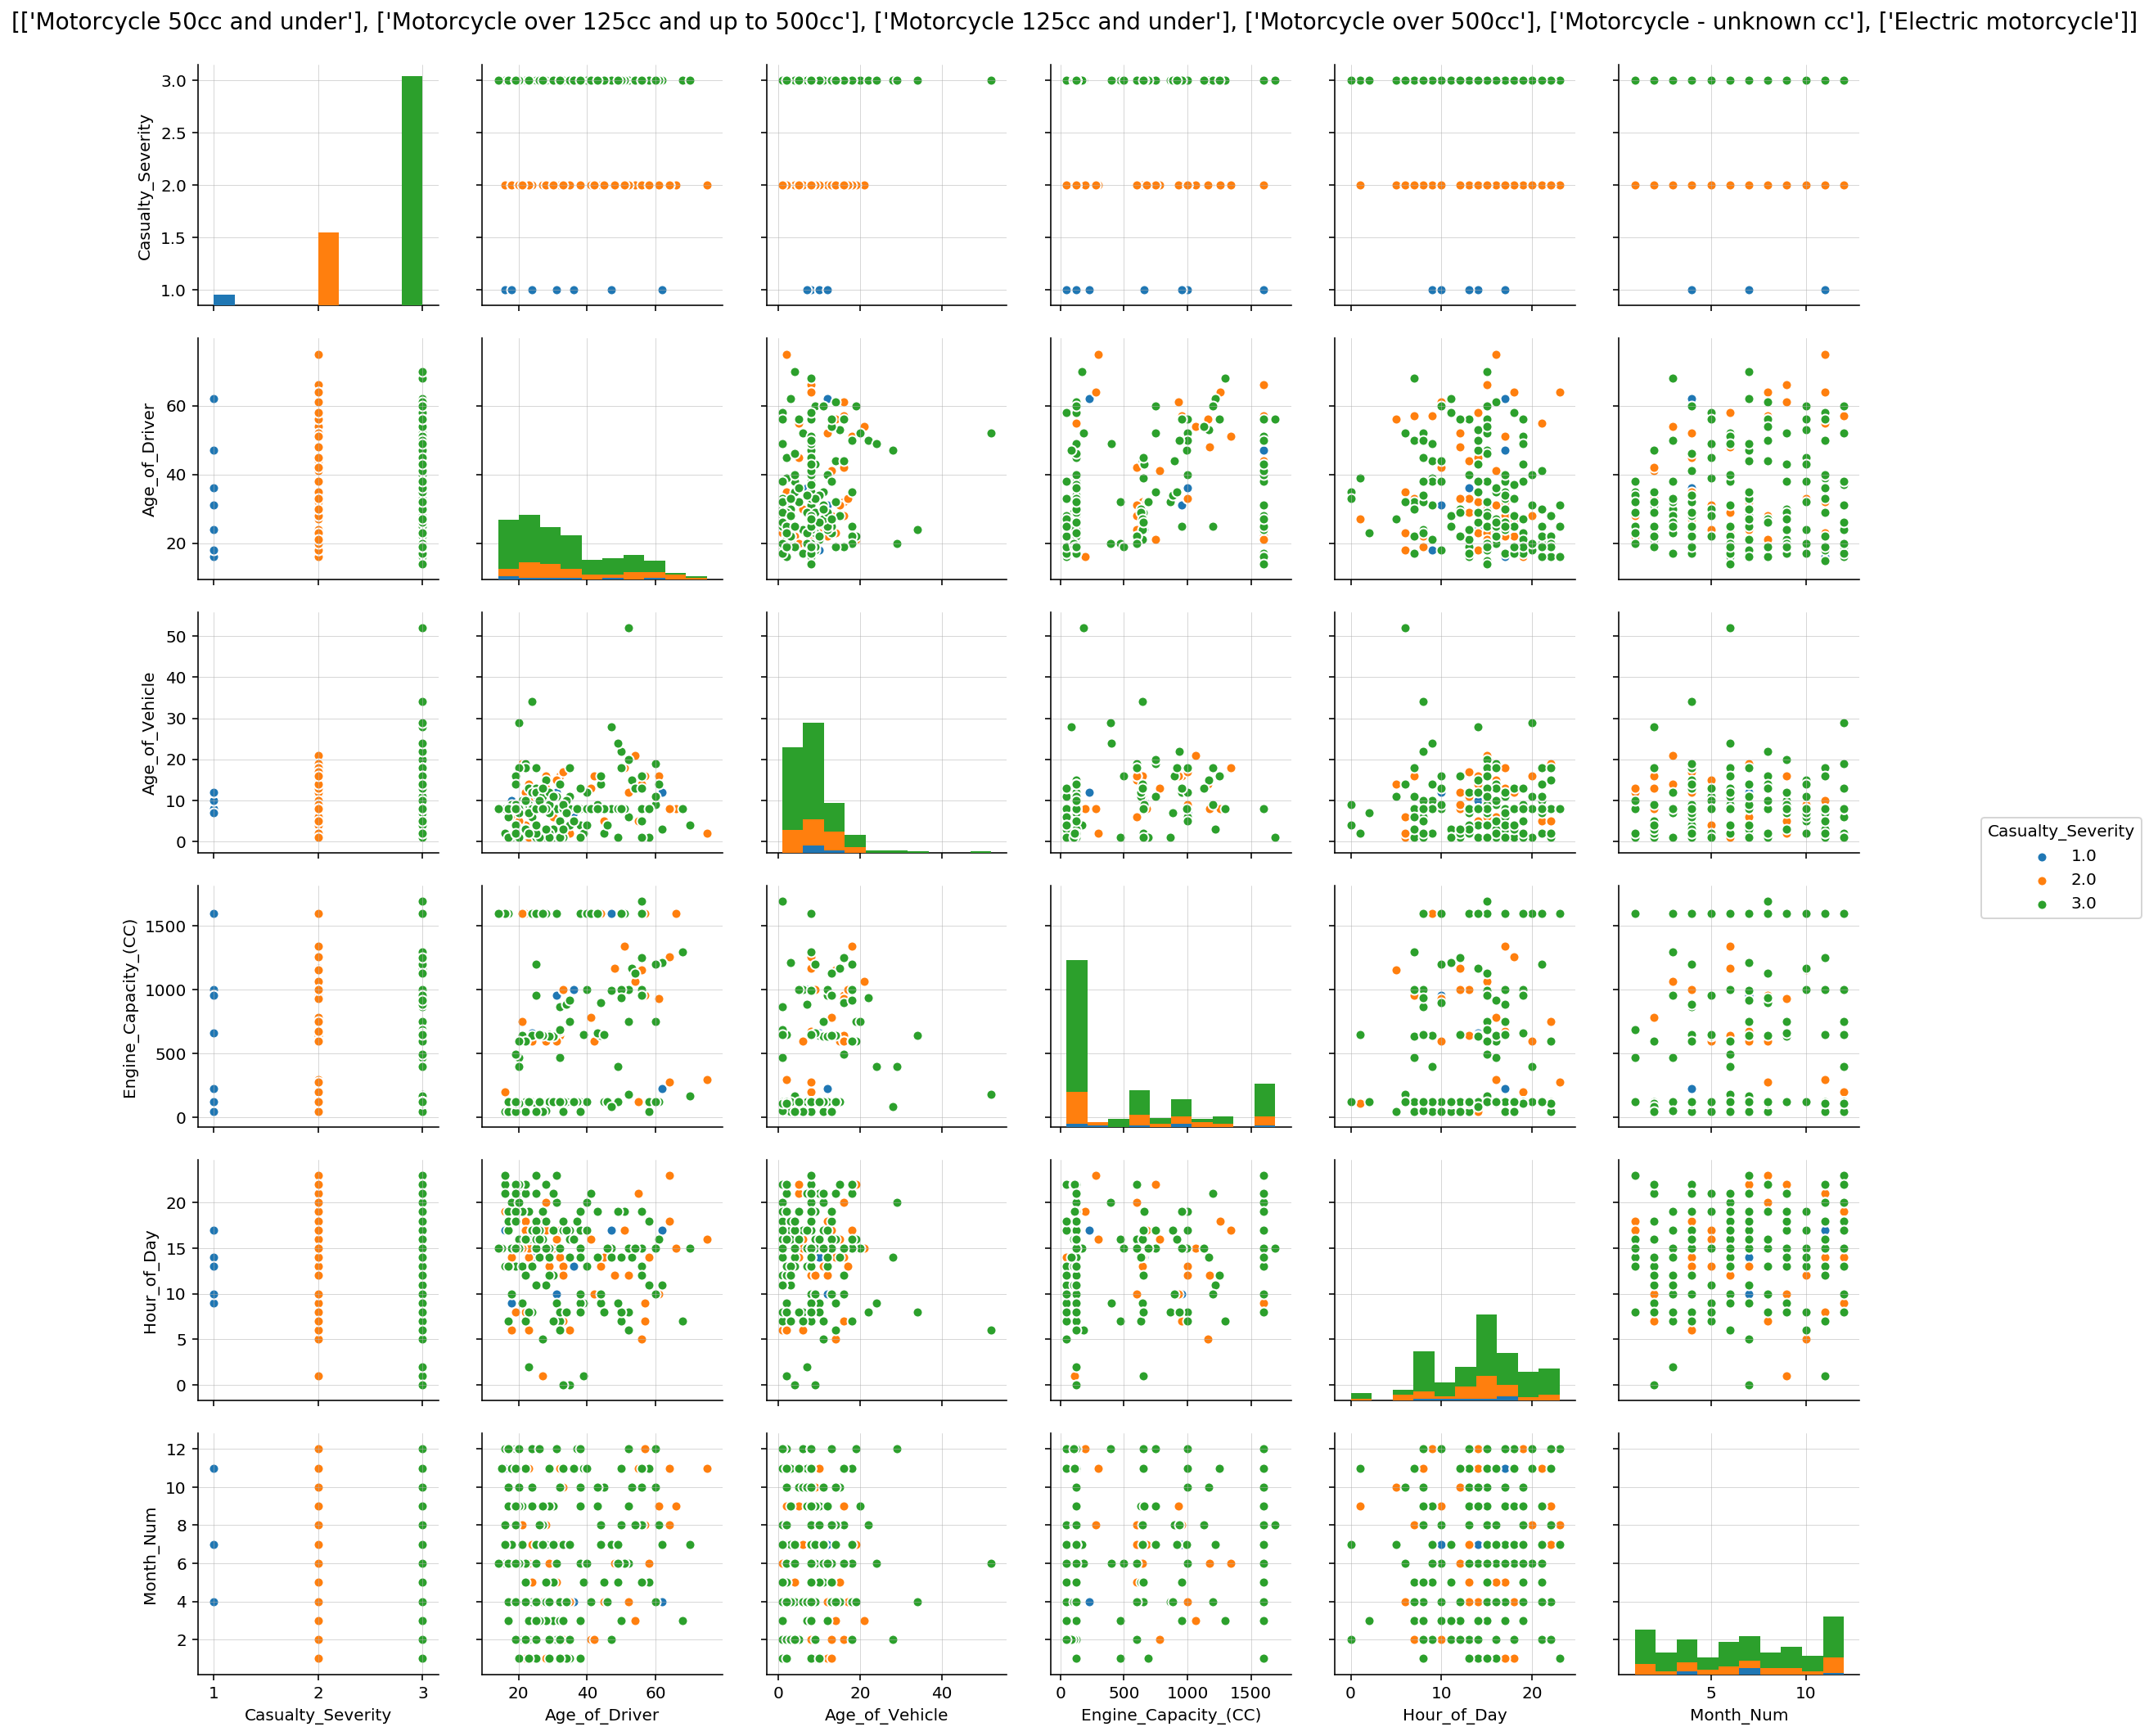

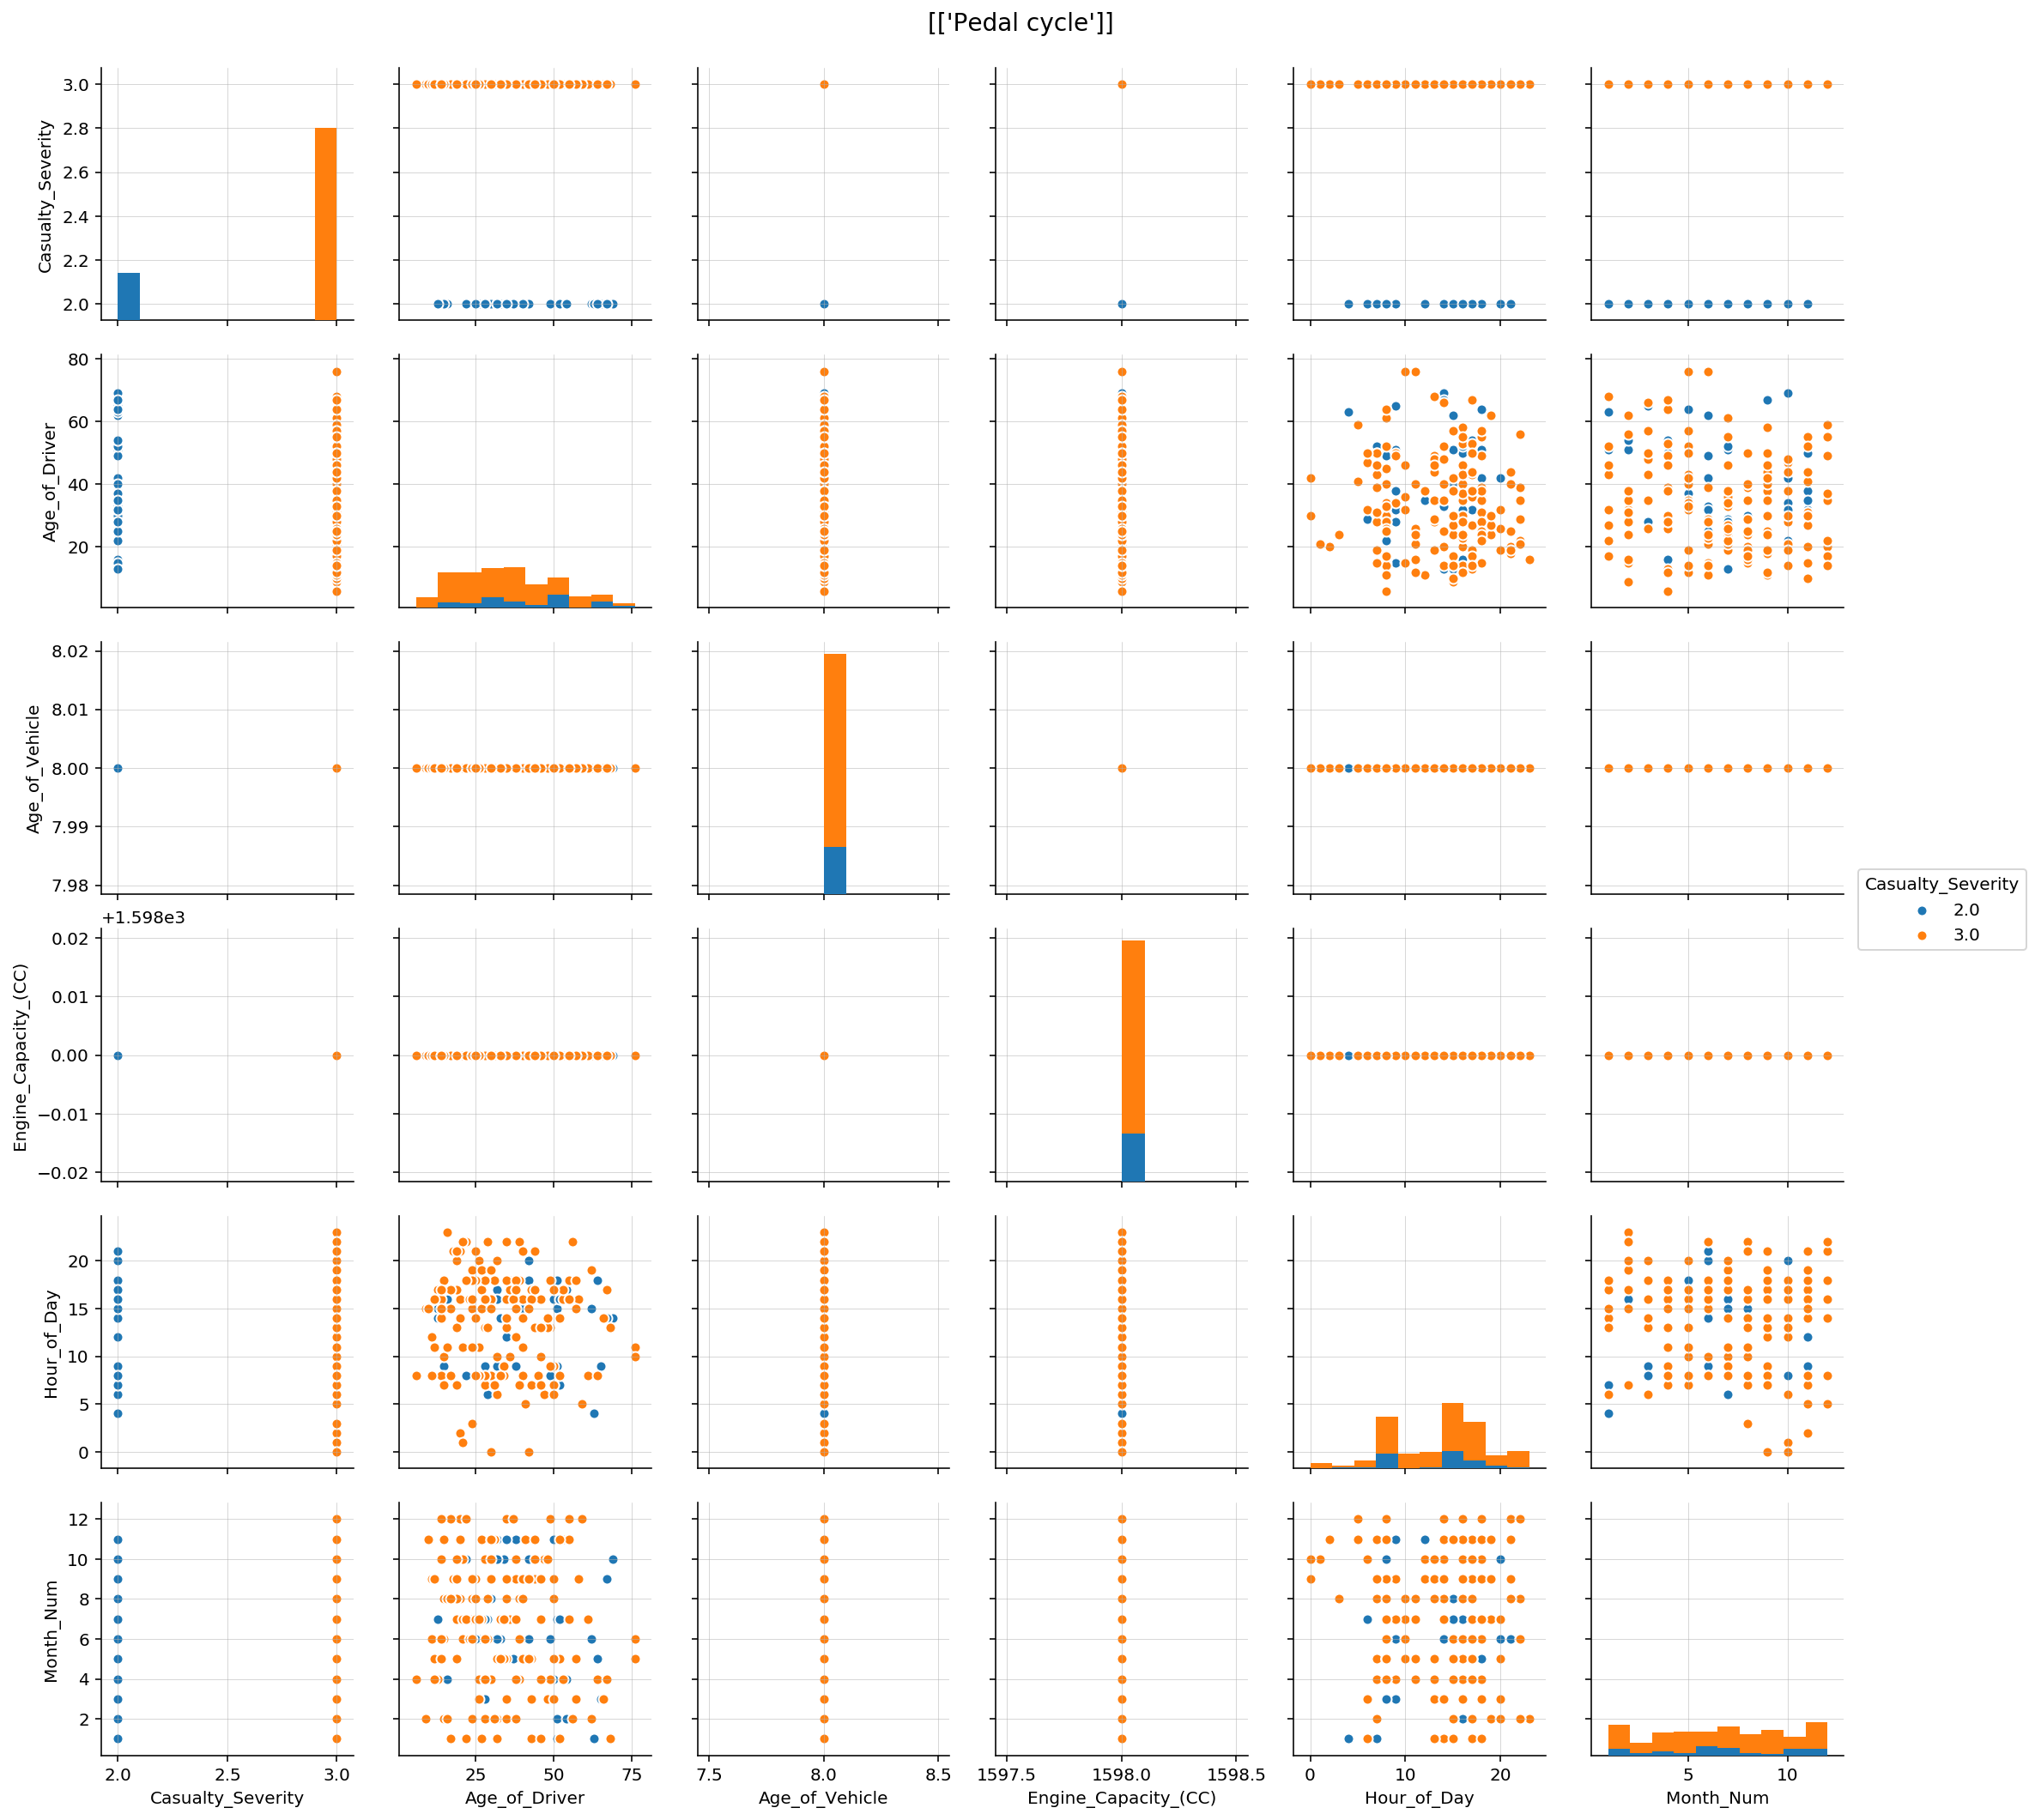

In [22]:
# Viewing vehicle type codes with labels
veh_dict = guide['Vehicle Type'].set_index("code").T.to_dict("list")

# Assigning masks for car, motorcycle and bicycle
car_mask = acc_cas_veh['Vehicle_Type'].isin(
    [k for k, v in veh_dict.items() if "car" in str(v).lower()])
motor_mask = acc_cas_veh['Vehicle_Type'].isin(
    [k for k, v in veh_dict.items() if "motorcycle" in str(v).lower()])
bike_mask = acc_cas_veh['Vehicle_Type'].isin(
    [k for k, v in veh_dict.items() if "pedal" in str(v).lower()])
car_mask.name, motor_mask.name, bike_mask.name = ["car", "motorcyle", "bicycle"]

# Repeating the intermediate task for pairplot only
mask_list = [car_mask, motor_mask, bike_mask]

def show_pairplots(mask):
    g = sns.pairplot(acc_cas_veh[mask].sample(frac=sample_size)[cols], 
                     plot_kws={"alpha": (0.01/sample_size)}, 
                     hue='Casualty_Severity')
    title = [veh_dict[i] for i in acc_cas_veh[mask]['Vehicle_Type'].unique()]
    g.fig.suptitle(title, fontsize=14)
    plt.subplots_adjust(top=0.95)       # Extra spacing for title
    return plt.show()

# Pairplots take a long time, adding options for sample size to reduce run time
sample_size = int(input("What sample size % would you like to evaluate? "))/100

# Iterating over the vehicle type masks
for mask in mask_list:
    show_pairplots(mask)

**Remove outliers that you can identify (if any), and justify your decisions.**

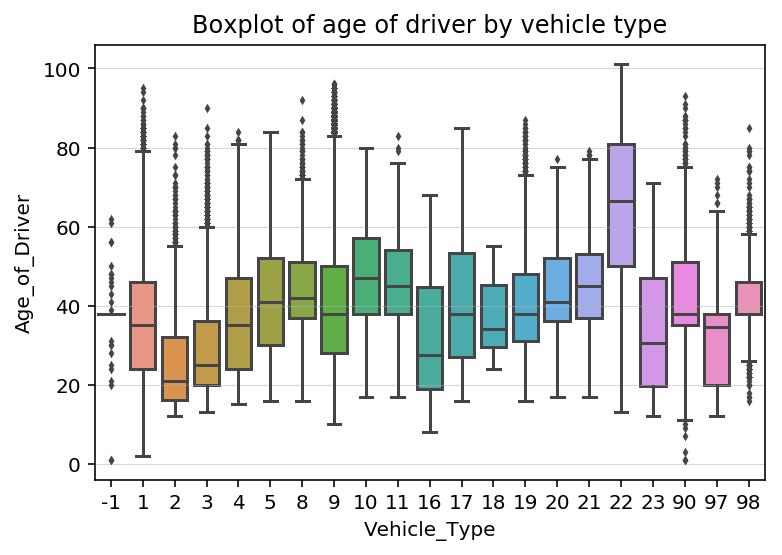

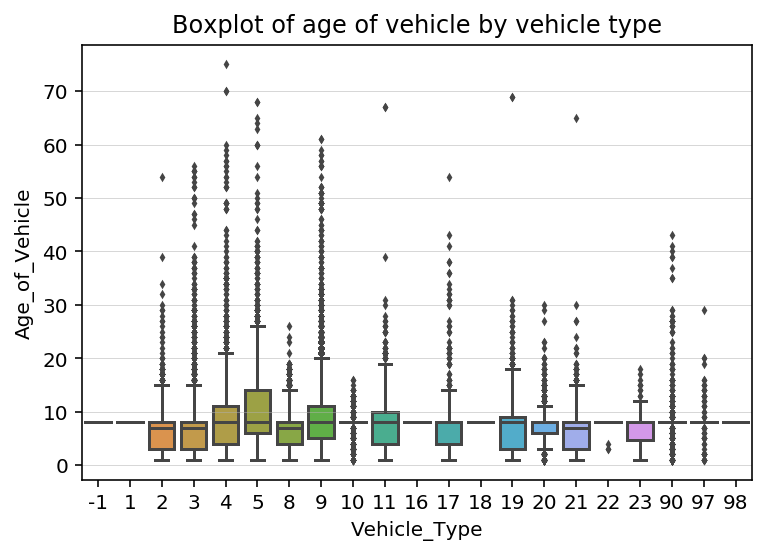

In [23]:
# Exploring age of driver outliers by boxplot
sns.boxplot(x='Vehicle_Type', y='Age_of_Driver', data=acc_cas_veh, fliersize=2)
plt.title("Boxplot of age of driver by vehicle type")
plt.show();

# Exploring age of vehicle outliers by boxplot
sns.boxplot(x='Vehicle_Type', y='Age_of_Vehicle', data=acc_cas_veh, fliersize=2)
plt.title("Boxplot of age of vehicle by vehicle type")
plt.show();

# Removing outliers for age of vehicle by vehicle type
for key in veh_dict.keys():
    acc_cas_veh = acc_cas_veh[~(
        # Iterating through vehicle type
        (acc_cas_veh['Vehicle_Type'] == key) &
        # Removing mean + 3 stds
        ((acc_cas_veh['Age_of_Vehicle'] - acc_cas_veh['Age_of_Vehicle'].mean())
         > (3*acc_cas_veh['Age_of_Vehicle'].std()))
    )]

# Removing outliers for age of driver by vehicle type
for key in veh_dict.keys():  
    acc_cas_veh = acc_cas_veh[~(
        # Iterating through vehicle type
        (acc_cas_veh['Vehicle_Type'] == key) &
        # Removing mean + 3 stds
        ((acc_cas_veh['Age_of_Driver'] - acc_cas_veh['Age_of_Driver'].mean())
         > (3*acc_cas_veh['Age_of_Driver'].std()))
    )]

- We can observe from `Age_of_Driver` and `Age_of_Vehicle` scatterplots and boxplots there are outliers
- In both scenarios, outliers vary by `Vehicle_Type`
- Outliers are right skewed (ie. they are older vehicles and elderly persons)
- Decided to remove outliers by mean + 3 standard deviations instead of IQR

**Using `MakeModel` data, identify 5 vehicle makes (separately for cars and motorcycles) that are most commonly involved in fatal accidents based on this data. Report proportion of accidents for these 10 vehicle makers.**

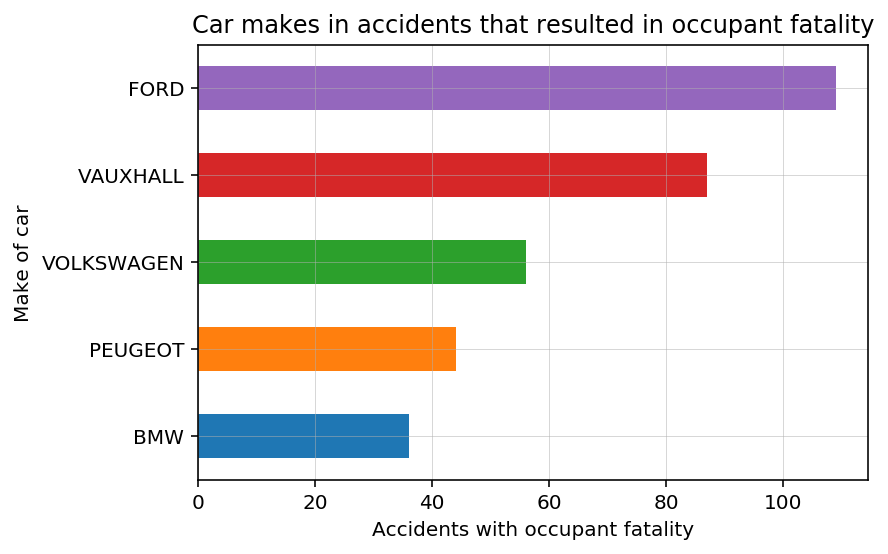

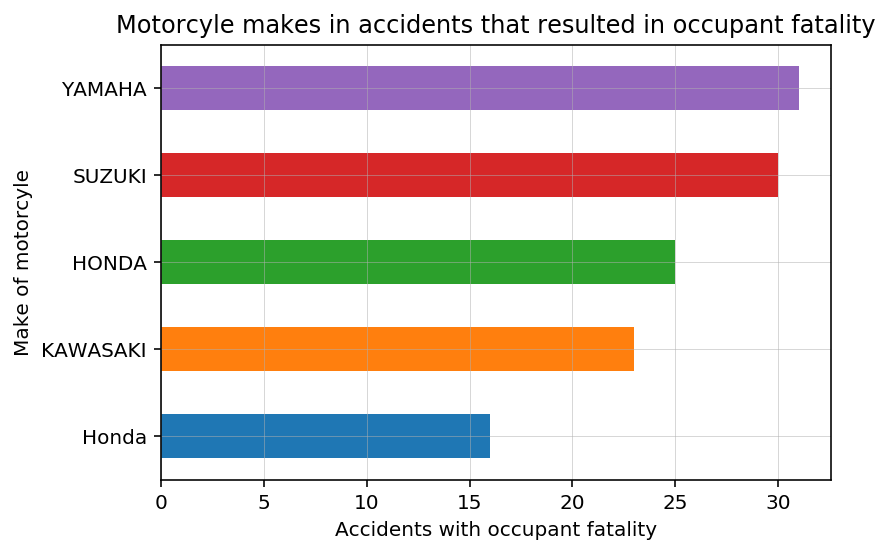

In [24]:
def occupant_fatality(vehicle, passenger, fatality):
    event = pd.concat((vehicle, passenger, fatality), axis=1).all(axis=1)
    result = make_cas[event].groupby('make')['Accident_Index'].nunique().nlargest()
    result.sort_values().plot(kind="barh")
    plt.title("{0} makes in accidents that resulted in occupant fatality"
             .format(vehicle.name.title()));
    plt.xlabel("Accidents with occupant fatality");
    plt.ylabel("Make of {0}".format(vehicle.name));
    return plt.show();

make_2016 = pd.read_csv("./data/uk-2016-road-safety-data/MakeModel2016.csv")

# Left join make dataset with casualty dataset
make_cas = pd.merge(make_2016, cas_2016, 
                    how="left", 
                    on=('Accident_Index', 'Vehicle_Reference'))

# Viewing casualty severity codes with labels
cas_sev_dict = guide['Casualty Severity'].set_index("code").T.to_dict("list")

# Assigning mask for casualty fatality
fatal_mask = make_cas['Casualty_Severity'] == 1   # Fatal

# Assigning masks for car and motorcycle occupants
car_pax_mask = make_cas['Casualty_Type'].isin(
    [k for k, v in veh_dict.items() if "car" in str(v).lower()])
motor_pax_mask = make_cas['Casualty_Type'].isin(
    [k for k, v in veh_dict.items() if "motorcycle" in str(v).lower()])

# Car makes most commonly involved in fatal accidents
occupant_fatality(car_mask, car_pax_mask, fatal_mask)

# Motorcycle makes most commonly involved in fatal accidents
occupant_fatality(motor_mask, motor_pax_mask, fatal_mask)

- The question was based on vehicle makes involved in a fatal accident. Therefore, we are looking at `['Accident_Index'].nunique()`
- If we wanted to count total casualties, we could have used `make_cas[event]['make'].value_counts()`
- There are more car occupant fatalities than motorcycle occupant fatalities

**What are most dangerous vehicle manoeuvres and why?**

In [25]:
def manoeuvre_fatality(casualty_class, fatality):
    print("Most dangerous vehicle manoeuvres resuling in {0} fatality: "
         .format(casualty_class.name))
    event = pd.concat((casualty_class, fatality), axis=1).all(axis=1)
    return display(make_cas[event]['Veh_Mnvr_label'].value_counts().head())
    
# Adding column for vehicle manoeuvre labels
mnvr_dict = guide['Vehicle Manoeuvre'].set_index("code").T.to_dict("list")
make_cas['Veh_Mnvr_label'] = make_cas['Vehicle_Manoeuvre'].replace(mnvr_dict)

# Viewing casualty class codes with labels
cas_class_dict = guide['Casualty Class'].set_index("code").T.to_dict("list")

# Assigning masks for driver, passenger and pedestrian 
drv_mask = make_cas['Casualty_Class'] == 1      # Driver
pax_mask = make_cas['Casualty_Class'] == 2      # Passenger 
ped_mask = make_cas['Casualty_Class'] == 3      # Pedestrian
drv_mask.name, pax_mask.name, ped_mask.name  = ["driver", "passenger", "pedestrian"]

# Most dangerous vehicle manoeuvres for driver fatality
manoeuvre_fatality(drv_mask, fatal_mask)

# Most dangerous vehicle manoeuvres for passenger fatality
manoeuvre_fatality(pax_mask, fatal_mask)

# Most dangerous vehicle manoeuvres for pedestrian fatality
manoeuvre_fatality(ped_mask, fatal_mask)

Most dangerous vehicle manoeuvres resuling in driver fatality: 


Going ahead other                      608
Going ahead left-hand bend             145
Going ahead right-hand bend            115
Overtaking moving vehicle - offside     70
Turning right                           32
Name: Veh_Mnvr_label, dtype: int64

Most dangerous vehicle manoeuvres resuling in passenger fatality: 


Going ahead other              160
Going ahead right-hand bend     46
Going ahead left-hand bend      32
Turning right                   13
Slowing or stopping             12
Name: Veh_Mnvr_label, dtype: int64

Most dangerous vehicle manoeuvres resuling in pedestrian fatality: 


Going ahead other    324
Turning right         23
Moving off            23
Reversing             14
Turning left          14
Name: Veh_Mnvr_label, dtype: int64

- The most dangerous vehicle manoeuvre is a vehicle going ahead other (ie. straight)

**Which initial point of impact is most dangerous and why?**

In [26]:
def impact_fatality(casualty_class, fatality):
    print("Most dangerous point of impact resulting in {0} fatality: "
          .format(casualty_class.name))
    event = pd.concat((casualty_class, fatality), axis=1).all(axis=1)
    return display(make_cas[event]['1st_POI_label'].value_counts().head())

# Adding column for 1st point of impact labels
impact_dict = guide['1st Point of Impact'].set_index("code").T.to_dict("list")
make_cas['1st_POI_label'] = make_cas['1st_Point_of_Impact'].replace(impact_dict)

# Most dangerous point of impact for driver fatality
impact_fatality(drv_mask, fatal_mask)

# Most dangerous point of impact for pedestrian fatality
impact_fatality(pax_mask, fatal_mask)

# Most dangerous point of impact for pedestrian fatality
impact_fatality(ped_mask, fatal_mask)

Most dangerous point of impact resulting in driver fatality: 


Front             714
Offside           151
Nearside          106
Back               54
Did not impact     23
Name: 1st_POI_label, dtype: int64

Most dangerous point of impact resulting in passenger fatality: 


Front             162
Nearside           58
Offside            36
Back               21
Did not impact     12
Name: 1st_POI_label, dtype: int64

Most dangerous point of impact resulting in pedestrian fatality: 


Front             327
Nearside           57
Offside            37
Back               14
Did not impact      9
Name: 1st_POI_label, dtype: int64

- The most dangerous point of impact (POI) is front-end collisions
- In UK, drivers sit on the right (offside) and passengers on the left (nearside)
    - second most dangerous POI for drivers is offside
    - second most dangerous POI for passengers is nearside

**Who are safer drivers: women or men, and why?**

In [27]:
def safe_drivers(veh_mask):
    for k, v in sorted(gender_dict.items())[1:3]:       # Male and female
        or_mask = pd.concat((veh_mask, 
                             make_cas['Sex_label'] == v[0]), 
                            axis=1).all(axis=1)
        and_mask = pd.concat((veh_mask, 
                              make_cas['Sex_label'].isin(["Male", "Female"])),
                             axis=1).all(axis=1)
        gender_acc = len(make_cas[or_mask]
                         .groupby(['Accident_Index', 'Vehicle_Reference'])
                         .size())
        total_acc = len(make_cas[and_mask]
                        .groupby(['Accident_Index', 'Vehicle_Reference'])
                        .size())
        gender_acc_pct = round(gender_acc/total_acc*100)
        print("{0} is involved in {1}% of {2} accidents"
              .format(v[0], gender_acc_pct, veh_mask.name))

# Adding column for sex of driver labels
gender_dict = guide['Sex of Driver'].set_index("code").T.to_dict("list")
make_cas['Sex_label'] = make_cas['Sex_of_Driver'].replace(gender_dict)

# Gender driving stats for cars
safe_drivers(car_mask)

# Gender driving stats for motorcycles
safe_drivers(motor_mask)

Male is involved in 66% of car accidents
Female is involved in 34% of car accidents
Male is involved in 84% of motorcyle accidents
Female is involved in 16% of motorcyle accidents


- Men are involved in 2/3 of car accidents. However, men travel twice the distance as women on average
    - *Men drive twice as many miles per year, on average, than women*
    - source: <http://www.brake.org.uk/facts-resources/1593-driver-gender>
- If we consider this, men are just as safe as women per distance travelled

**What is safer in terms of number of fatalities in severe car accidents: rear or front seats, and why?**

In [28]:
# Viewing car passenger codes with labels
seat_dict = guide['Car Passenger'].set_index("code").T.to_dict("list")
                                                        
# Assigning masks for seating and accident severity
fatal_mask = acc_cas_veh['Casualty_Severity'] == 1      # Fatal
front_mask = acc_cas_veh['Car_Passenger'] == 1          # Front seat
rear_mask = acc_cas_veh['Car_Passenger'] == 2           # Rear seat
front_mask.name, rear_mask.name = ["front seat", "rear seat"]
seat_mask_list = [front_mask, rear_mask]
sev_fatal_mask = acc_cas_veh['Accident_Severity'].isin(["Fatal"])
sev_srs_mask = acc_cas_veh['Accident_Severity'].isin(["Fatal", "Serious"])
sev_no_mask = (acc_cas_veh['Accident_Severity'] == "all") | True
sev_fatal_mask.name = "fatal"
sev_srs_mask.name = "serious"
sev_no_mask.name = "reported"

def seating_fatality(seat_mask_list, sev_mask = sev_no_mask):
    print("In a {0} accident: ".format(sev_mask.name))
    for seat_mask in seat_mask_list:
        seat_fatal_mask = pd.concat((seat_mask, 
                                     sev_mask, 
                                     fatal_mask), axis=1).all(axis=1)
        seat_total_mask = pd.concat((seat_mask, 
                                     sev_mask), axis=1).all(axis=1)
        seat_fatal_cnt = len(acc_cas_veh[seat_fatal_mask]
                             .groupby(['Accident_Index', 'Casualty_Reference'])
                             .size())
        seat_total_cnt = len(acc_cas_veh[seat_total_mask]
                             .groupby(['Accident_Index', 'Casualty_Reference'])
                             .size())
        seat_fatal_pct = round(seat_fatal_cnt/seat_total_cnt*100, 2)
        print("{0}% of {1} passengers resulted in a fatality"
              .format(seat_fatal_pct, seat_mask.name))

# Seating fatality for all reported accidents
seating_fatality(seat_mask_list)

# Seating fatality for all serious accidents
seating_fatality(seat_mask_list, sev_srs_mask)

# Seating fatality for all fatal accidents
seating_fatality(seat_mask_list, sev_fatal_mask)

In a reported accident: 
0.79% of front seat passengers resulted in a fatality
0.72% of rear seat passengers resulted in a fatality
In a serious accident: 
4.74% of front seat passengers resulted in a fatality
3.87% of rear seat passengers resulted in a fatality
In a fatal accident: 
41.75% of front seat passengers resulted in a fatality
31.03% of rear seat passengers resulted in a fatality


- It's safer to sit at the back
- This make sense since the most dangerous point of impact is front-end collisions
- Used `acc_cas_veh` dataframe as it allows an additional mask for `Accident_Severity`

### Bonus

**Plot accident locations using Geopandas. User color coding to indicate incident severity.**

In [29]:
geometry = [Point(xy) for xy in zip(acc_2016['Longitude'], 
                                    acc_2016['Latitude'])]

# Converting to geodataframe
acc_gdf = gpd.GeoDataFrame(acc_2016.drop(['Longitude', 'Latitude'], axis=1),
                           crs={"init": "epsg:4326"},   # For long, lat
                           geometry = geometry)

# Loading shapefile with UK countries
countries = gpd.read_file("./data/subdivisions/gadm36_GBR_1.shp")

# Countries
countries.set_index('NAME_1', inplace=True)
countries['Centroid'] = countries['geometry'].centroid  # Centre point

# Seting figure and axis
fig, ax = plt.subplots(figsize=(12,12))

# Adding base map of UK
countries.plot(cmap='Pastel2', ax=ax, linewidth=0.5, edgecolor="k")

# Plotting accidents for each severity
p1 = acc_gdf[acc_gdf['Accident_Severity'] == "Fatal"]
p1.plot(ax=ax, color="red", alpha=0.5, markersize=1, label="Fatal")
p2 = acc_gdf[acc_gdf['Accident_Severity'] == "Serious"]
p2.plot(ax=ax, color="blue", alpha=0.2, markersize=1, label="Serious")
p3 = acc_gdf[acc_gdf['Accident_Severity'] == "Slight"]
p3.plot(ax=ax, color="green", alpha=0.1, markersize=1, label="Slight")

# Adding country labels
box = dict(boxstyle="round", facecolor="linen", alpha=1)
for point in countries.iterrows():
    ax.text(point[1]['Centroid'].x,
            point[1]['Centroid'].y,
            point[0],
            horizontalalignment="center",
            bbox=box)

ax.set_position([0,0,1,1,])
ax.set_xlim(-8.5, 2)
ax.set_ylim(49.5, 61)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend(title="Accident Severity", markerscale=5)

# Saving figure to a file
# plt.savefig("UK_accident_locations.png", dpi=108)
plt.show()

DriverError: ./data/subdivisions/gadm36_GBR_1.shp: No such file or directory

<img src="UK_accident_locations.png" alt="UK accident locations" title="UK accident location"/>
- Accidents by severity plotted onto a basemap of UK
- Can see a concentration of accidents in London, Birmingham and Glasgow

**What other interesting relationships can you identify in the dataset?**

In [ ]:
# Loading shapefile with LSOA boundaries
lsoa = gpd.read_file("./data/LSOA/Lower_Layer_Super_Output_Areas_December_2011_Full_Extent__Boundaries_in_England_and_Wales.shp")

# Transforming to latitude and longitude co-ordinates
lsoa.to_crs(epsg=4326, inplace=True)

# Copying dataframe with columns required
acc_count = acc_2016[['Accident_Index', 'LSOA_of_Accident_Location']].copy()

# Renaming LSOA columns
lsoa.rename(columns={'lsoa11cd':'LSOA'}, inplace=True)
acc_count.rename(columns={'LSOA_of_Accident_Location':'LSOA'}, inplace=True)

# Adding new column for count of accidents per LSOA
acc_count = acc_count.groupby(['LSOA']).size().reset_index()
acc_count.rename(columns={0:'Accident_Count'}, inplace=True)

# Converting to geodataframe
acc_count = gpd.GeoDataFrame(acc_count, crs={"init": "epsg:4326"})

# Left join LSOA dataset with accident count dataset
lsoa_count = pd.merge(lsoa, acc_count, how="left", on='LSOA')

# Replacing NaN values as 0
lsoa_count['Accident_Count'].fillna(0, inplace=True)

# Seting figure and axis
fig, ax = plt.subplots(figsize=(12,12))

lsoa_count.plot(ax=ax, column='Accident_Count', scheme="fisher_jenks", 
                cmap="OrRd", legend=True, linewidth=0.1, edgecolor="grey")

ax.set_position([0,0,1,1,])
ax.set_xlim(-7, 2)
ax.set_ylim(49.5, 56)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Saving figure to a file
# plt.savefig("LSOA_accident_locations.png", dpi=108)
plt.show()

<img src="LSOA_accident_locations.png" alt="LSOA accident locations" title="LSOA accident locations"/>
- Count of accidents plotted per LSOA in England and Wales
- LSOA (Lower Layer Super Output Areas) is a geographic area, like a postcode, that contains roughly 1500 people
- LSOA areas in dark red have had multiple accidents reported. Therefore, if you live or work in these areas, expect to pay a higher premium for insurance

**What interesting questions can you ask/answer about/using the dataset?**

**Which day of the week has the most accidents?**

In [ ]:
# Replacing day of week codes with labels
day_dict = guide['Day of Week'].set_index("code").T.to_dict("list")
acc_2016['Day_of_Week'] = acc_2016['Day_of_Week'].replace(day_dict)

acc_2016.groupby('Day_of_Week')['Accident_Index'].count().sort_values(ascending=False)

- Friday

**Are EVs safer than internal combustion engine cars for occupant safety?**

In [ ]:
# Viewing propulsion codes with labels
engine_dict = guide['Vehicle Propulsion Code'].set_index("code").T.to_dict("list")

# Viewing casualty severity codes with labels
cas_class_dict = guide['Casualty Class'].set_index("code").T.to_dict("list")

# Assigning mask for car driver and passenger
car_pax_mask = acc_cas_veh['Casualty_Class'].isin([1, 2])   # driver and passenger

# Seting figure and axis
fig, ax = plt.subplots(figsize=(12,12))

for k, v in engine_dict.items():
    if isinstance(k, int) and (np.sum(acc_cas_veh['Propulsion_Code'] == k) > 100):
        eng_mask = acc_cas_veh['Propulsion_Code'] == k
        pax_eng_mask = pd.concat((car_pax_mask, eng_mask), axis=1).all(axis=1)
        g = acc_cas_veh[pax_eng_mask]['Casualty_Severity'].value_counts()
        g.plot(ax=ax, logy=True, label=v[0])
        for x, y in enumerate(g):
            ax.text(g.index[x], y+0.02, str(y), fontsize=12)

ax.legend(title="Engine type")
x_labels = [cas_sev_dict[x] for x in g.index[::-1]]
ax.set_xticklabels(x_labels)
plt.xticks(range(1,4))
plt.title("Count of casualty severity by engine type");
plt.xlabel("Casualty class");
plt.ylabel("Count");
plt.show();

- Not enough data to assess EV safety
- Judging by slope and proportions of fatalities
    - Hybrid electric is safest
    - Petrol is most dangerous